In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from utils.path import WildcardPath
import os
from utils.enums import ToolEnum, FeatureEnum as FE, FeatureDirectionEnum as FDE, FeatureTypeEnum as FTE
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import alignment.ensemble
import alignment.dataset
import utils.plots
from features.labels import LabelCandidateExtractor
from features.pairwise import _CUSTOM_METRICS
from utils.dataloading import load_balibase_results

In [2]:
DATA_DIR = WildcardPath("/hits/fast/cme/bodynems/data/")
RESULT_DIR = WildcardPath("/hits/fast/cme/bodynems/MSA_difficulty/results")

# run_suffix = ""
# run_suffix = "_muscle5"
run_suffix = "_benchmark"
# run_suffix = "_reduced"

BENCHMARKS = ["balibase3/RV11" + run_suffix, "balibase3/RV12" + run_suffix]

OUTPUT_DIR = DATA_DIR / "output" / "{benchmark}"
TOOL_DIR = OUTPUT_DIR / "{dataset}" / "{tool}"

DATASETS = OUTPUT_DIR.format(benchmark=BENCHMARKS[0]).listdir(dirs_only=True)
_file_suffix_map = {
    "": "_multi",
    "_muscle5": "_muscle5",
    "_benchmark": "_benchmark",
    "_reduced": "_reduced",
}
file_suffix = _file_suffix_map[run_suffix]

benchmark_mapping = dict(zip(BENCHMARKS, ["RV11 (hard)", "RV12 (easy)"]))

In [5]:
id_cols = ["benchmark", "dataset", "tool"]
(
    unaligned_features,
    aligned_features,
    aligned_cols,
    reference_features,
    confusion_features,
    runtime_msa_df,
    runtime_scores_df,
) = load_balibase_results(BENCHMARKS, benchmarking_msa=True)

tool
Mafft_FFT-NS-2    1296
Mafft_L-INS-i     1296
Mafft_G-INS-i     1296
ClustalO          1296
Muscle5           1296
Muscle3           1296
Name: count, dtype: int64
dataset
BBS12024.msf    48
BBS11037.msf    48
BB11013.msf     48
BB11015.msf     48
BBS11008.msf    48
Name: count, dtype: int64
unaligned: (162, 87)
aligned: (1134, 215)
confusion: (1134, 18)
reference: (972, 30)


In [4]:
corr_coef = aligned_features.n_sequences.corr(aligned_features.max_sequence_length)
print("correlation between #taxa and seq_len:", corr_coef)

correlation between #taxa and seq_len: 0.13229940496722545


In [9]:
for enum in [FE.HOMOLOGY_POS_DIST, FE.HOMOLOGY_SEQ_DIST, FE.SSP_DIST]:
    test_df = FE.extract_from_df(
        aligned_features, enum, statistic_filter="mean", keep_string_cols=False
    )
    print(enum, np.median(np.sort(np.abs(test_df.iloc[:, 0] - test_df.iloc[:, 1]))))

homology_pos_dist 0.0
homology_seq_dist 0.0
symmetrized_sp_dist 0.0


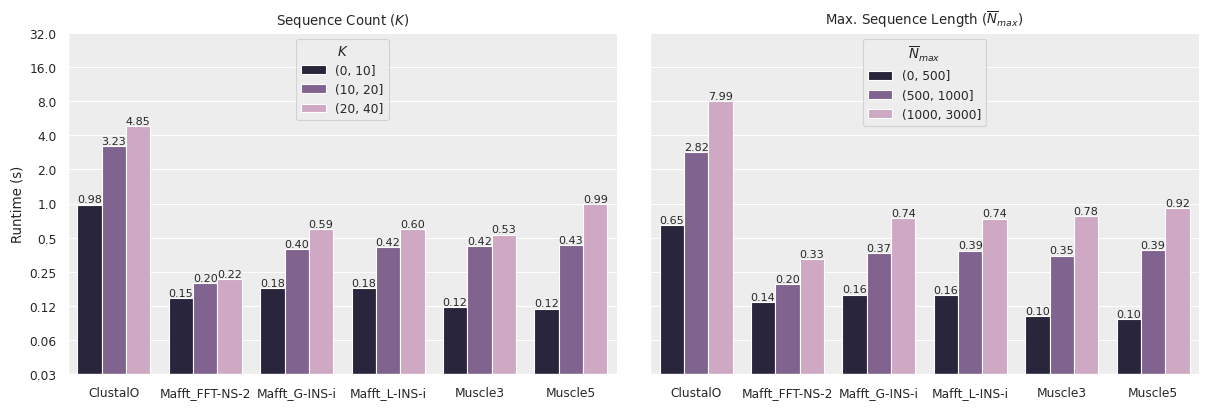

In [9]:
import matplotlib.ticker as ticker
import matplotlib.scale as scale

plot_df = runtime_msa_df.sort_values(id_cols)
plot_df.loc[plot_df.tool == "Muscle5", ["mean", "median"]] = (
    plot_df.loc[plot_df.tool == "Muscle5", ["mean", "median"]] / 8.0
)
statistic = "median"
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
fig.tight_layout()
palette = sn.color_palette("ch:s=-.1,r=.3")
size_col = "$K$"
plot_df[size_col] = pd.cut(plot_df["n_sequences"], bins=[0, 10, 20, 40])
sn.barplot(
    plot_df,
    y=statistic,
    x="tool",
    hue=size_col,
    ax=axes[0],
    palette=palette[::-2],
    errorbar=None,
)
axes[0].set_title("Sequence Count (" + r"$K$" + ")")
axes[0].set_ylabel("Runtime (s)")
axes[0].set_xlabel("")
# axes[0].legend().set_title("")
sn.move_legend(axes[0], "upper center", ncols=1)

size_col = r"$\overline{N}_{max}$"
plot_df[size_col] = pd.cut(plot_df["max_sequence_length"], bins=[0, 500, 1000, 3000])
# plot_df[size_col] = pd.qcut(plot_df["max_sequence_length"], q=3)
sn.barplot(
    plot_df,
    y=statistic,
    x="tool",
    hue=size_col,
    ax=axes[1],
    palette=palette[::-2],
    errorbar=None,
)
axes[1].set_title("Max. Sequence Length (" + r"$\overline{N}_{max}$" + ")")
axes[1].set_xlabel("")
sn.move_legend(axes[1], "upper center", ncols=1)
for i in range(2):
    for j in range(3):
        axes[i].bar_label(axes[i].containers[j], fontsize=8, fmt="{:.2f}")

# y_locs = [0,  0.25, 0.5, 1, 2, 8]
# y_range = range(len(y_locs))
# plt.yticks(y_range, y_locs)
# fig.gca().yaxis.set_major_locator(ticker.FixedLocator([0, 0.1, 0.25, 0.5, 1, 2, 4, 8]))

plt.yscale(scale.LogScale(axis=axes[0], base=2))
_ = plt.yticks(ticks=plt.yticks()[0], labels=np.round(plt.yticks()[0], 2))
fig.savefig(
    RESULT_DIR / "balibase3" / "aligner_runtime_comparison.svg", bbox_inches="tight"
)

unaligned: (799, 87)
aligned: (5593, 195)
confusion: (5593, 18)


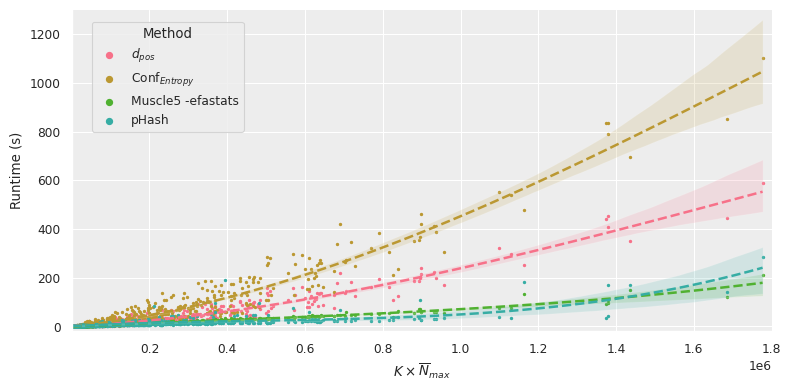

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.scale as scale

*_, runtime_scores_df = load_balibase_results(
    ["treebase"], with_reference=False, benchmarking_scores=True
)


candidates = [
    FE.HOMOLOGY_POS_DIST,
    # FE.HOMOLOGY_SEQ_DIST,
    # FE.SSP_DIST,
    FE.CONFUSION_ENTROPY,
    # FE.CONFUSION_DISPLACEMENT,
    # FE.CONFUSION_SET,
    FE.DISPERSION,
    FE.PERC_HASH_HAMMING,
]
candidate_names = [
    "homology_pos_dist",
    # "homology_seq_dist",
    # "symmetrized_sp_dist",
    "confusion_entropy",
    # "confusion_displacement",
    # "confusion_set",
    "dispersion",
    "perc_hash_hamming_dist_16bit",
]
pretty_names = [enum.pretty for enum in candidates]
pretty_names[-2] = "Muscle5 -efastats"

plot_df = runtime_scores_df[runtime_scores_df.tool == "all"].sort_values(id_cols)
plot_df = plot_df.rename(dict(zip(candidate_names, pretty_names)), axis=1)
size_col = r"$K \times \overline{N}_{max}$"
plot_df[size_col] = plot_df["n_sequences"] * plot_df["max_sequence_length"]
plot_df = plot_df.melt(
    id_vars=id_cols + ["max_sequence_length", "n_sequences", size_col],
    value_vars=pretty_names,
    var_name="Method",
    value_name="Runtime (s)",
)


markers = ["o", ".", "<", "P", "*", "s"]
# markers = dict(zip(pretty_names, markers))

grid = sn.lmplot(
    plot_df,
    x=size_col,
    y="Runtime (s)",
    hue="Method",
    # robust=True,
    # style="Method",
    # linestyles=[""]
    # errorbar=None,
    # logx=True,
    order=3,
    # markers=markers,
    scatter_kws={"s": 2, "alpha": 1},
    palette=sn.color_palette("husl"),
    height=4,
    aspect=2,
)
sn.move_legend(
    grid,
    "upper left",
    numpoints=5,
    markerscale=3,
    bbox_to_anchor=(0.11, 0.95),
    frameon=True,
    fancybox=True,
)
plt.ylim(-20, 1300)
plt.xlim(1000, 1.8e6)

ax = grid.axes[0, 0]
styles = ["--", "-.", "-", ":"]
for line, style in zip(ax.get_lines(), styles):
    line.set_linestyle("--")

grid.savefig(RESULT_DIR / "treebase" / "treebase_runtime.svg", bbox_inches="tight")

/tmp/ipykernel_1576740/2488689580.py:65: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10)


,$d_{pos}$,$d_{seq}$,$d_{SSP}$
count,1134.000000,1134.0,1.134000e+03
mean,0.000076,0.0,2.234590e-16
std,0.001124,0.0,6.246364e-16
min,0.000000,0.0,0.000000e+00
25%,0.000000,0.0,0.000000e+00
50%,0.000000,0.0,0.000000e+00
75%,0.000000,0.0,1.983208e-16
max,0.036333,0.0,8.470933e-15


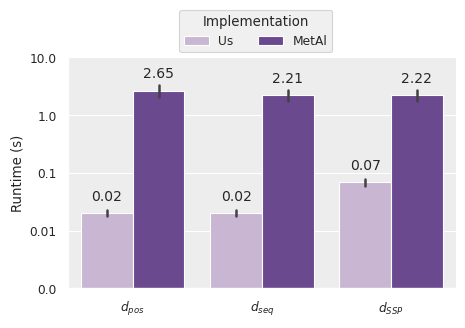

In [ ]:
import matplotlib.scale as scale

perf_df_a = []
perf_df_b = []
val_df_a = []
val_df_b = []
homology_enums = [FE.HOMOLOGY_POS_DIST, FE.HOMOLOGY_SEQ_DIST, FE.SSP_DIST]
pretty_names = [enum.pretty for enum in homology_enums]
for enum in homology_enums:
    perf_df_a.append(runtime_scores_df[enum])
    perf_df_b.append(runtime_scores_df[enum + "_metal"])
    val_df_a.append(aligned_features["mean_" + enum])
    val_df_b.append(aligned_features["mean_" + enum + "_metal"])

perf_df_a.append(runtime_scores_df[id_cols])
perf_df_b.append(runtime_scores_df[id_cols])
perf_df_a = pd.concat(perf_df_a, axis=1)
perf_df_b = pd.concat(perf_df_b, axis=1)
perf_df_a.columns = pretty_names + id_cols
perf_df_b.columns = pretty_names + id_cols
perf_df_a["Source"] = "Us"
perf_df_b["Source"] = "MetAl"

val_df_a.append(aligned_features[id_cols])
val_df_b.append(aligned_features[id_cols])
val_df_a = pd.concat(val_df_a, axis=1)
val_df_b = pd.concat(val_df_b, axis=1)
val_df_a.columns = pretty_names + id_cols
val_df_b.columns = pretty_names + id_cols
val_df_a["Source"] = "Us"
val_df_b["Source"] = "MetAl"


perf_plot_df = pd.concat((perf_df_a, perf_df_b), axis=0, ignore_index=True)
perf_plot_df = perf_plot_df.melt(
    id_cols + ["Source"],
    value_vars=pretty_names,
    var_name="Method",
    value_name="Runtime (s)",
)

val_plot_df = pd.concat((val_df_a, val_df_b), axis=0, ignore_index=True)
us_mask = val_plot_df.Source == "Us"
val_plot_df = (
    val_plot_df.loc[us_mask, pretty_names].reset_index(drop=True)
    - val_plot_df.loc[~us_mask, pretty_names].reset_index(drop=True)
).abs() / (val_plot_df.loc[~us_mask, pretty_names].reset_index(drop=True) + 1e-8)

###### Plotting ######

fig = plt.figure(figsize=(5, 3))
fig.tight_layout()
ax = fig.gca()
sn.barplot(
    perf_plot_df,
    x="Method",
    y="Runtime (s)",
    hue="Source",
    palette=sn.color_palette("Paired")[8:10],
)
ax.bar_label(ax.containers[0], fontsize=10, fmt="{:.2f}", padding=7)
ax.bar_label(ax.containers[1], fontsize=10, fmt="{:.2f}", padding=7)
ax.set_yscale(scale.LogScale(axis=ax, base=10))
_ = ax.set_yticks(ax.get_yticks(), np.round(ax.get_yticks(), 2))
plt.ylim(0, 10)
fig.legend(
    title="Implementation", loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.06)
)
ax.legend().remove()
ax.set_xlabel("")
fig.savefig(
    RESULT_DIR / "balibase3" / "metric_runtime_comparison.svg", bbox_inches="tight"
)

# sn.heatmap(val_plot_df.to_numpy())
# val_plot_df.round(8).value_counts()
val_plot_df.describe()

In [ ]:
from utils.path import WildcardPath
from alignment.dataset import Dataset
from alignment.alignment import Alignment
import pandas as pd
import numpy as np

DATA_DIR = WildcardPath("/hits/fast/cme/bodynems/data/")
DATA_DIR = WildcardPath("/hits/fast/cme/TreeBase")
msa = Alignment(DATA_DIR / "11359_1.phy", data_type="AA")
msa.msa

raw = []
for seq in msa.msa:
    raw.append(len(str(seq.seq).replace("-", "")))

raw = pd.Series(raw)
raw.describe()

count      45.000000
mean     8998.311111
std       211.852095
min      8529.000000
25%      8964.000000
50%      9014.000000
75%      9038.000000
max      9795.000000
dtype: float64